In [1]:
#importing libraries
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class DecisionTree():

  WHITE_NODE = "white_node"

  def __init__(self, max_depth, minimal_instances_for_split=0):
    self.max_depth = max_depth
    self.minimal_instances_for_split = minimal_instances_for_split

  def _get_best_feature_key(self, best_feature):

    return best_feature[0] if isinstance(best_feature,tuple) else best_feature

  def _class_probabilities(self, y):

    number_of_unique_classes = len(y)
    unique_class_counts = y.value_counts()
    return [class_count/number_of_unique_classes for class_count in unique_class_counts]

  def _entropy(self, y) -> float:

    probabilities = self._class_probabilities(y)
    return sum([-p * np.log2(p) for p in probabilities if p>0])

  def _information_gain(self, y, y_subsets) -> float:

    entropy_parent = self._entropy(y)
    entropy_children = 0
    total_samples = len(y)
    for y_subset in y_subsets:
      subset_size = len(y_subset)
      if subset_size == 0: #doubt
        continue
      entropy_children += (subset_size / total_samples) * self._entropy(y_subset)
    gain = entropy_parent - entropy_children
    return gain

  def _best_split(self,X,y,feature_list):

    best_gain = -1
    best_feature = None

    for feature in feature_list:
       X_column = X[feature]
       if X_column.dtype in [np.float64, np.int64]:
          sorted_indices = X_column.argsort()
          X_sorted = X_column.iloc[sorted_indices]
          y_sorted = y.iloc[sorted_indices]

          thresholds = []
          prev_value = None
          for idx, value in enumerate(X_sorted):
              if prev_value is None or value != prev_value:
                  if idx > 0:
                      threshold = (prev_value + value) / 2.0
                      thresholds.append(threshold)
                  prev_value = value

          for threshold in thresholds:
              y_subset_left = y.iloc[np.argwhere(X_column.to_numpy() <= threshold).flatten()]
              y_subset_right = y.iloc[np.argwhere(X_column.to_numpy() > threshold).flatten()]
              y_subsets = [y_subset_left, y_subset_right]
              info_gain = self._information_gain(y, y_subsets)
              if info_gain > best_gain:
                  best_gain = info_gain
                  best_feature = (feature, threshold)
       else:
          y_subsets = [y[X_column == value] for value in np.unique(X_column)]
          info_gain = self._information_gain(y, y_subsets)
          if info_gain > best_gain:
              best_gain = info_gain
              best_feature = feature

    return best_feature


  def _split_tree(self, feature_to_split_on, X, y):

    tree = {}
    y_subsets = dict()

    if isinstance(feature_to_split_on, tuple):  # Numerical split
        feature, threshold = feature_to_split_on
        X_column = X.loc[:, feature]
        left_mask = np.argwhere(X_column.to_numpy() <= threshold).flatten()
        right_mask = np.argwhere(X_column.to_numpy() > threshold).flatten()

        tree['<= {}'.format(threshold)] = np.unique(y.iloc[left_mask])[0] if len(np.unique(y.iloc[left_mask])) == 1 else self.WHITE_NODE
        tree['> {}'.format(threshold)] = np.unique(y.iloc[right_mask])[0] if len(np.unique(y.iloc[right_mask])) == 1 else self.WHITE_NODE

    else:  # Categorical split
        X_column = X.loc[:,feature_to_split_on]
        feature_unique_values = np.unique(X_column)
        for feature_value in feature_unique_values:
            y_subset = y[X_column == feature_value]
            unique_classes = np.unique(y_subset)
            tree[feature_value] = unique_classes[0] if len(unique_classes) == 1 else self.WHITE_NODE

    return tree

  def _build_tree(self, root, X, y, previous_feature_value, depth, attribute_values_with_majority_class):

    label_col = y.columns[0]

    if X.shape[0]>self.minimal_instances_for_split and depth < self.max_depth:
      feature_list = X.columns.tolist()

      sqrt_num_features = int(np.sqrt(len(feature_list)))
      selected_features = random.sample(feature_list, sqrt_num_features)

      best_feature = self._best_split(X, y, selected_features)

      if best_feature is None:
        root[previous_feature_value] = y[label_col].value_counts().idxmax()
        return

      best_feature_key = self._get_best_feature_key(best_feature)
      # feature_list.remove(best_feature_key)

      tree = self._split_tree(best_feature, X, y)
      next_root = None

      for attribute in attribute_values_with_majority_class[best_feature_key]:
          if attribute not in tree.keys():
            tree[attribute] = attribute_values_with_majority_class[best_feature_key][attribute]

      if previous_feature_value is None:
          root[best_feature_key] = tree
          next_root = root[best_feature_key]
      else:
        root[previous_feature_value] = {}
        root[previous_feature_value][best_feature_key] = tree
        next_root = root[previous_feature_value][best_feature_key]

      depth= depth+1

      for feature, value in list(next_root.items()):
        if value == self.WHITE_NODE:
           X_column = X.loc[:,best_feature_key]
           if feature.startswith('<='):
            y_filtered = y.iloc[np.argwhere(X_column.to_numpy() <= best_feature[1]).flatten()]
            X_filtered = X.iloc[np.argwhere(X_column.to_numpy() <= best_feature[1]).flatten()]
           elif feature.startswith('>'):
            y_filtered = y.iloc[np.argwhere(X_column.to_numpy() > best_feature[1]).flatten()]
            X_filtered = X.iloc[np.argwhere(X_column.to_numpy() > best_feature[1]).flatten()]
           else:
            y_filtered = y[X[best_feature_key] == feature]
            X_filtered = X[X[best_feature_key] == feature]
           self._build_tree(next_root, X_filtered, y_filtered, feature, depth,attribute_values_with_majority_class)
    else:
        root[previous_feature_value] = y[label_col].value_counts().idxmax()

  def _fit(self, X, y):

      tree = {}
      depth = 0
      attribute_values_with_majority_class = {}
      for column in X.columns:
        value_maj_cls = {}
        for value in X[column].unique():
          value_maj_cls[value] = y[X[column] == value ].value_counts().idxmax()[0]
        attribute_values_with_majority_class[column] = value_maj_cls
      self._build_tree(tree, X, y, None, depth, attribute_values_with_majority_class)
      return tree


  def _make_prediction(self, tree_structure, input_instance):

    while isinstance(tree_structure, dict):
      first_node = list(tree_structure.keys())[0]
      if first_node not in input_instance:
        return None
      feature_value = input_instance[first_node]
      if isinstance(tree_structure[first_node], dict):
              for key in tree_structure[first_node].keys():
                if key.startswith('<='):
                  split_value = float(key.split('<= ')[1])
                  if feature_value<=split_value:
                    tree_structure = tree_structure[first_node][key]
                    break
                elif key.startswith('>'):
                  split_value = float(key.split('> ')[1])
                  if feature_value>split_value:
                    tree_structure = tree_structure[first_node][key]
                    break
                else:
                  if feature_value in tree_structure[first_node]:
                    tree_structure = tree_structure[first_node][feature_value]
                    break

      else:
        return None
    return tree_structure

In [3]:
class RandomForest():

  def __init__(self,n_trees):
    self.n_trees = n_trees

  def prepare_data(self, data, label_column_name):
      X = data.sample(frac=1).reset_index(drop=True)
      y = pd.DataFrame(X[label_column_name], index=X.index)
      X = X.drop(label_column_name, axis=1)
      return X, y

  def split_data(self, X, y, k):
      classes, counts = np.unique(y, return_counts=True)
      train_test_sets = []
      for i in range(k):
          test_class_indices = np.array([])
          for class_label, count in zip(classes, counts):
              class_count = int(count * (1 / k))
              test_class_indices = np.concatenate((test_class_indices, np.array(np.where(y == class_label)[0][i * class_count:(i + 1) * class_count])))
          train_class_indices = np.array(X.index.difference(test_class_indices))
          X_train = X.iloc[train_class_indices]
          y_train = y.iloc[train_class_indices]
          X_test = X.iloc[test_class_indices]
          y_test = y.iloc[test_class_indices]
          train_test_sets.append((X_train, y_train, X_test, y_test))
      return train_test_sets

  def train_model(self, X_train, y_train, max_depth, minimal_instances_for_split):

      classifier = []

      for i_tree in range(self.n_trees):
          sample_indices = X_train.sample(n=len(X_train), replace=True).index
          sampled_X_train = X_train.loc[sample_indices]
          sampled_y_train = y_train.loc[sample_indices]

          dt = DecisionTree(max_depth, minimal_instances_for_split)
          tree = dt._fit(sampled_X_train, sampled_y_train)
          classifier.append(tree)

      return classifier

  def get_majority_with_random_tie(self, row):
    counts = np.bincount(row)
    max_count = np.max(counts)
    max_indices = np.where(counts == max_count)[0]
    if len(max_indices) == 1:
        return max_indices[0]
    else:
        return np.random.choice(max_indices)

  def predict(self, X_test, classifier):
      n_trees_result = np.zeros((len(X_test), len(classifier)), int)

      for idx,tree in enumerate(classifier):
        dt = DecisionTree(-1, -1)
        for i in range(X_test.shape[0]):
            input_instance = X_test.iloc[i]
            n_trees_result[i][idx] = dt._make_prediction(tree, input_instance)

      predictions = np.apply_along_axis(self.get_majority_with_random_tie, axis=1, arr=n_trees_result)

      return predictions


In [4]:
def confusion_matrix(true_label, pred_label, classes):
  matrix = np.zeros((len(classes), len(classes)), int)
  for y, y_hat in zip(true_label, pred_label):
    if y in classes and y_hat in classes:
      matrix[classes.tolist().index(y), classes.tolist().index(y_hat)] += 1
  return matrix

def accuracy(true_label, pred_label):
    classes = np.unique(pred_label)
    confusion = confusion_matrix(true_label, pred_label, classes)
    correct = np.sum(np.diag(confusion))
    total = np.sum(confusion)
    return correct / total if total > 0 else 0.0

def precision(true_label, pred_label, positive_class_idx=0):
    classes = np.unique(pred_label)
    confusion = confusion_matrix(true_label, pred_label, classes)
    true_positives = confusion[positive_class_idx, positive_class_idx]
    predicted_positives = np.sum(confusion[:, positive_class_idx])
    return true_positives / predicted_positives if predicted_positives > 0 else 0.0

def recall(true_label, pred_label, positive_class_idx=0):
    classes = np.unique(pred_label)
    confusion = confusion_matrix(true_label, pred_label, classes)
    true_positives = confusion[positive_class_idx, positive_class_idx]
    actual_positives = np.sum(confusion[positive_class_idx, :])
    return true_positives / actual_positives if actual_positives > 0 else 0.0

def evaluate(y_test, predictions):
    classes = np.unique(y_test)
    acc = accuracy(y_test, predictions)
    prec = []
    rec = []
    for class_idx,class_label in enumerate(classes):
      prec.append(precision(y_test, predictions, class_idx))
      rec.append(recall(y_test, predictions, class_idx))
    mean_prec = np.mean(prec)
    mean_rec = np.mean(rec)
    f1 = (2 * mean_prec * mean_rec)/ (mean_prec + mean_rec)
    return acc,mean_prec,mean_rec,f1

In [5]:
def run_random_forests(data,class_label,k=10,max_depth=10, minimal_instances_for_split=10):

    n_trees = [1, 5, 10, 20, 30, 40, 50]

    metrics_across_forests = {n: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0} for n in n_trees}
    for n_tree in tqdm(n_trees):
        rf = RandomForest(n_tree)
        X, y = rf.prepare_data(data, class_label)
        train_test_sets = rf.split_data(X, y, k)

        metrics = {'accuracy':[],'precision':[],'recall':[],'f1':[]}

        for X_train, y_train, X_test, y_test in train_test_sets:
            classifier = rf.train_model(X_train, y_train, max_depth, minimal_instances_for_split)
            predictions = rf.predict(X_test, classifier)
            acc, prec, rec, f1 = evaluate(y_test[class_label].values, predictions = predictions)
            metrics['accuracy'].append(acc)
            metrics['precision'].append(prec)
            metrics['recall'].append(rec)
            metrics['f1'].append(f1)

        for metric in metrics.keys():
          metrics_across_forests[n_tree][metric] = np.mean(metrics[metric])

    print("Metrics across forests:", list(metrics_across_forests.items()))

    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        plt.figure(figsize=(8, 6))
        for n_tree in n_trees:
            plt.plot(n_tree, metrics_across_forests[n_tree][metric], 'o', label=f'Ntree={n_tree}')
        plt.xlabel('Ntree')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} vs. Ntree')
        plt.legend()
        plt.grid(True)
        plt.show()

### Voting Dataset

In [6]:
voting_data = pd.read_csv("/content/hw3_house_votes_84.csv")

100%|██████████| 7/7 [11:48<00:00, 101.15s/it]


Metrics across forests: [(1, {'accuracy': 0.9261904761904761, 'precision': 0.9217645592425004, 'recall': 0.9247596153846154, 'f1': 0.9231877539616343}), (5, {'accuracy': 0.9547619047619047, 'precision': 0.9549678846339598, 'recall': 0.9538461538461538, 'f1': 0.9543146205425102}), (10, {'accuracy': 0.9476190476190476, 'precision': 0.9449924794704205, 'recall': 0.945673076923077, 'f1': 0.9453074206147429}), (20, {'accuracy': 0.9595238095238094, 'precision': 0.9567652472369964, 'recall': 0.9600961538461539, 'f1': 0.9584008839144456}), (30, {'accuracy': 0.9547619047619047, 'precision': 0.9513226881620843, 'recall': 0.95625, 'f1': 0.953745680966318}), (40, {'accuracy': 0.9547619047619047, 'precision': 0.9499638637506285, 'recall': 0.9562500000000002, 'f1': 0.95308488485144}), (50, {'accuracy': 0.9642857142857142, 'precision': 0.9614676404749932, 'recall': 0.9651442307692306, 'f1': 0.9632576258005111})]


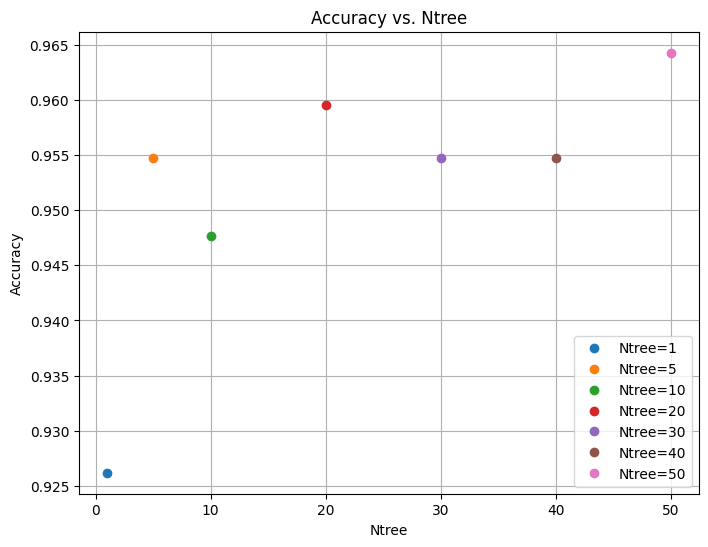

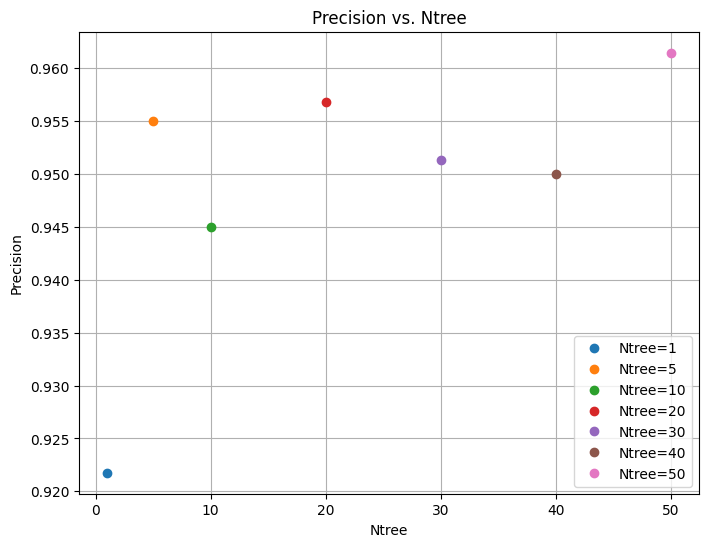

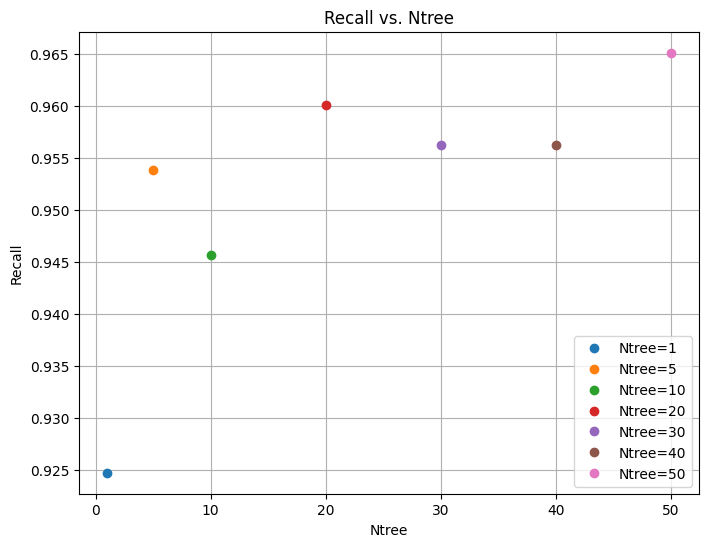

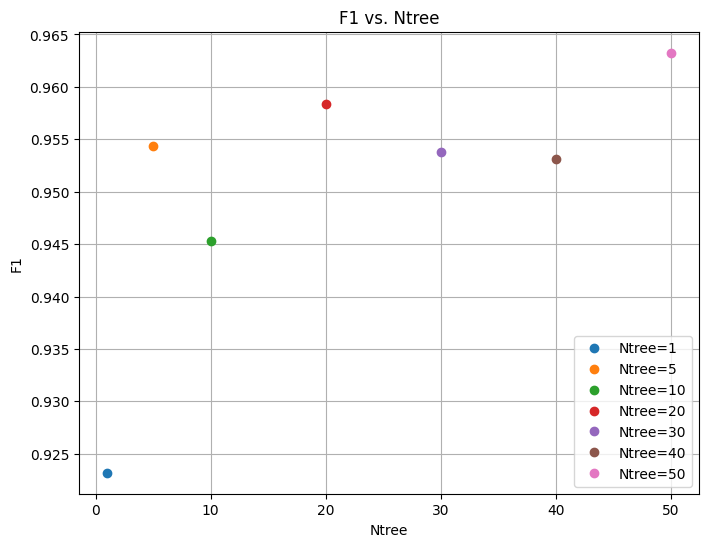

In [7]:
run_random_forests(voting_data, 'class')

### Wine Dataset

In [8]:
wine_data = pd.read_csv("/content/hw3_wine.csv", sep = '\t')

100%|██████████| 7/7 [1:33:03<00:00, 797.65s/it] 


Metrics across forests: [(1, {'accuracy': 0.90625, 'precision': 0.920277777777778, 'recall': 0.9171428571428573, 'f1': 0.9185980922231082}), (5, {'accuracy': 0.9375, 'precision': 0.9543121693121694, 'recall': 0.9323809523809524, 'f1': 0.942926011563533}), (10, {'accuracy': 0.95, 'precision': 0.9511111111111111, 'recall': 0.9600000000000002, 'f1': 0.955514736825755}), (20, {'accuracy': 0.96875, 'precision': 0.9691269841269842, 'recall': 0.9726190476190476, 'f1': 0.9708600751487781}), (30, {'accuracy': 0.98125, 'precision': 0.9836111111111112, 'recall': 0.9838095238095239, 'f1': 0.9836825172696001}), (40, {'accuracy': 0.975, 'precision': 0.9769444444444444, 'recall': 0.9773809523809524, 'f1': 0.9770955017398532}), (50, {'accuracy': 0.9875, 'precision': 0.9877777777777779, 'recall': 0.9904761904761905, 'f1': 0.9891157037600553})]


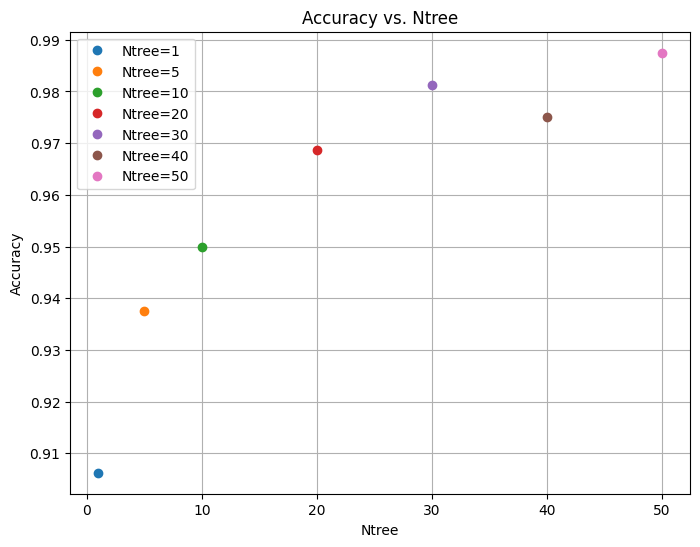

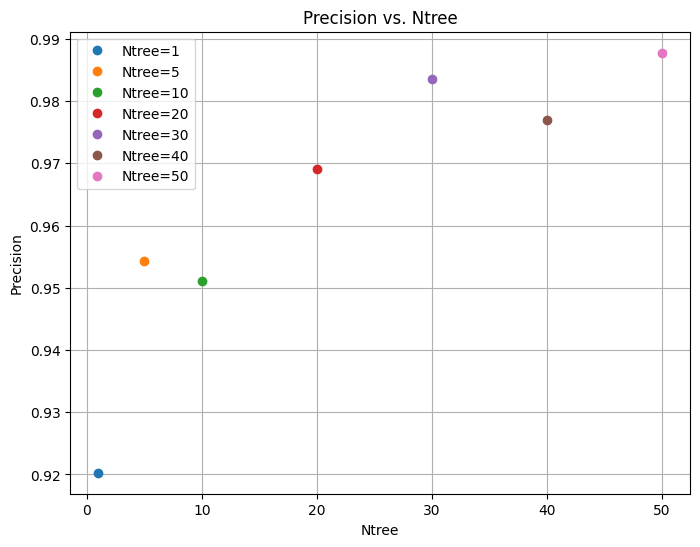

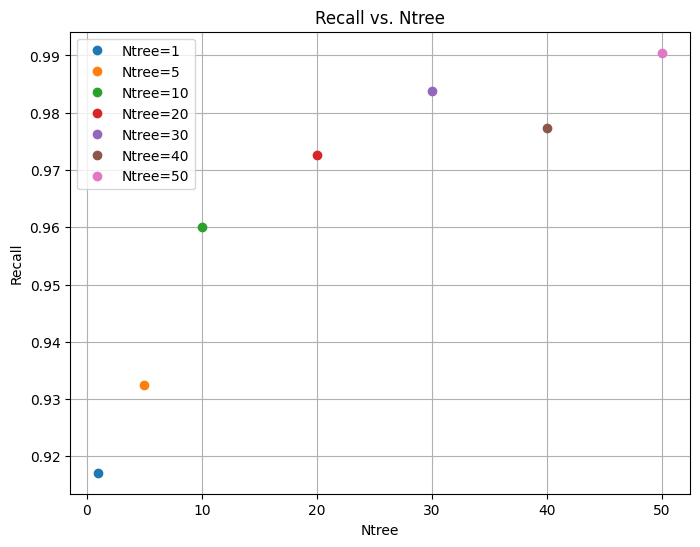

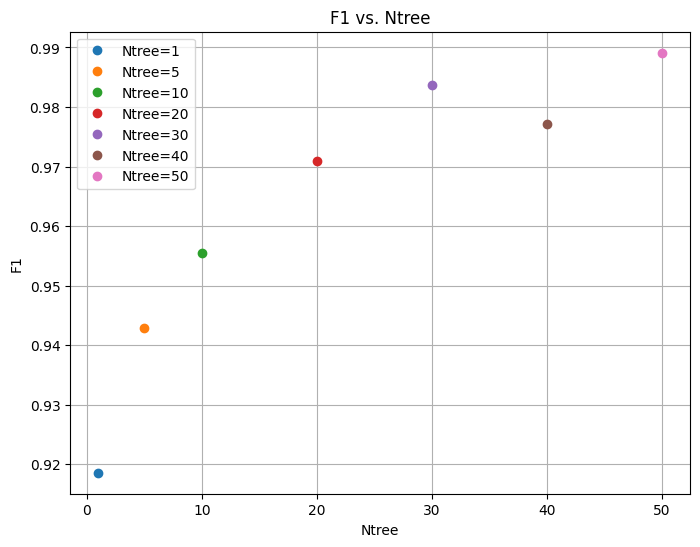

In [9]:
run_random_forests(wine_data, '# class')

### Breast Cancer Dataset

In [10]:
cancer_data = pd.read_csv("/content/hw3_cancer.csv", sep = '\t')

100%|██████████| 7/7 [13:35<00:00, 116.53s/it]


Metrics across forests: [(1, {'accuracy': 0.9352517985611511, 'precision': 0.9359662753211371, 'recall': 0.9210164835164836, 'f1': 0.9283082935020002}), (5, {'accuracy': 0.9597122302158274, 'precision': 0.9534486487164469, 'recall': 0.9584020146520146, 'f1': 0.9559130279460394}), (10, {'accuracy': 0.9582733812949641, 'precision': 0.9510938318629624, 'recall': 0.9582875457875458, 'f1': 0.9546659212561313}), (20, {'accuracy': 0.9597122302158272, 'precision': 0.95369174438607, 'recall': 0.9593864468864469, 'f1': 0.9564889195436053}), (30, {'accuracy': 0.9654676258992806, 'precision': 0.9589176602272994, 'recall': 0.966735347985348, 'f1': 0.9627906387330494}), (40, {'accuracy': 0.9654676258992806, 'precision': 0.959900830541101, 'recall': 0.9647664835164835, 'f1': 0.962310388176113}), (50, {'accuracy': 0.9582733812949641, 'precision': 0.9531445238042251, 'recall': 0.9563186813186814, 'f1': 0.9546981307490994})]


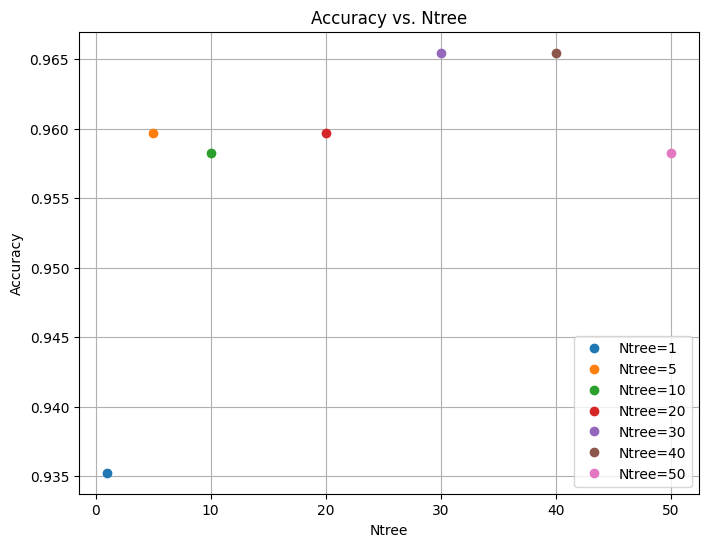

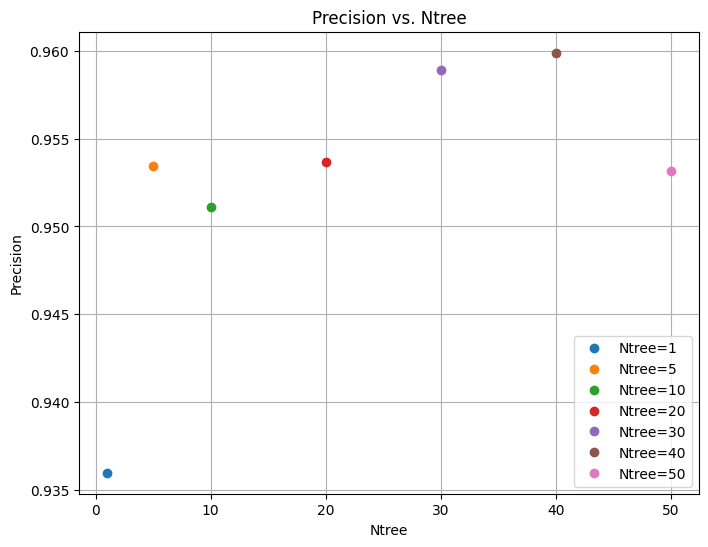

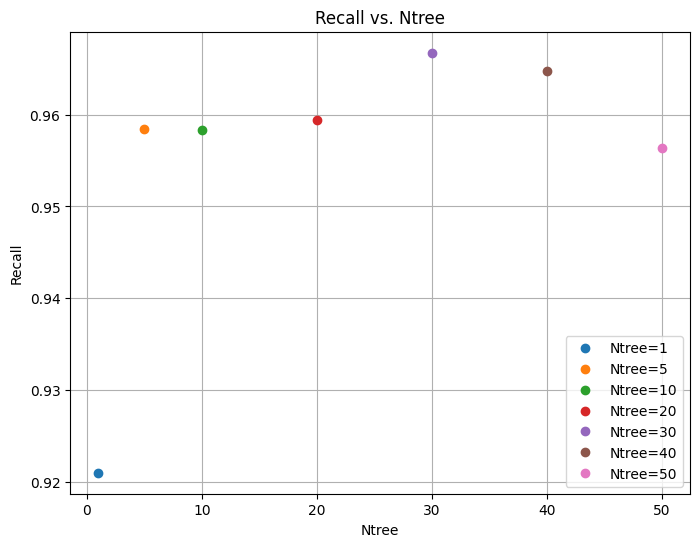

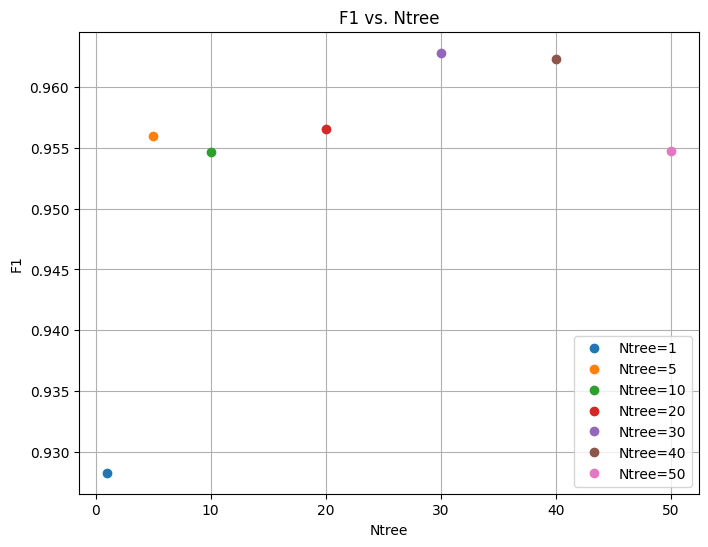

In [11]:
k=5
run_random_forests(cancer_data, 'Class', k)

### Contraceptive Dataset

In [ ]:
!pip3 install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
contraceptive_method_choice = fetch_ucirepo(id=30)
X = contraceptive_method_choice.data.features
y = contraceptive_method_choice.data.targets

metadata = contraceptive_method_choice.variables
# Iterate through columns and convert to appropriate type
for col_name, col_type in zip(metadata['name'], metadata['type']):
  if col_name not in X.columns:
    continue
  if col_type == 'Integer':
      X[col_name] = X[col_name].astype(np.int64)
  else:
      X[col_name] = X[col_name].astype(str)
X["class"] = y


<ipython-input-44-ede27aa54398>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_name] = X[col_name].astype(np.int64)
<ipython-input-44-ede27aa54398>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_name] = X[col_name].astype(str)


100%|██████████| 7/7 [28:40<00:00, 245.78s/it]


Metrics across forests: [(1, {'accuracy': 0.4757679180887372, 'precision': 0.4763396551720285, 'recall': 0.4606944741532977, 'f1': 0.46815543922359126}), (5, {'accuracy': 0.5071672354948805, 'precision': 0.5003744007293405, 'recall': 0.4838017825311943, 'f1': 0.4915965645951396}), (10, {'accuracy': 0.5324232081911262, 'precision': 0.5298261807144804, 'recall': 0.5120351752822341, 'f1': 0.5206825408218576}), (20, {'accuracy': 0.5262798634812287, 'precision': 0.5209478487929344, 'recall': 0.5031933452168746, 'f1': 0.5119020717877747}), (30, {'accuracy': 0.5372013651877132, 'precision': 0.5314042852460373, 'recall': 0.5150469399881163, 'f1': 0.5229186097101465}), (40, {'accuracy': 0.5344709897610922, 'precision': 0.5232399913342147, 'recall': 0.5125314319667261, 'f1': 0.517762423124403}), (50, {'accuracy': 0.5453924914675768, 'precision': 0.5361668655642542, 'recall': 0.5274086749851457, 'f1': 0.5317262438131973})]


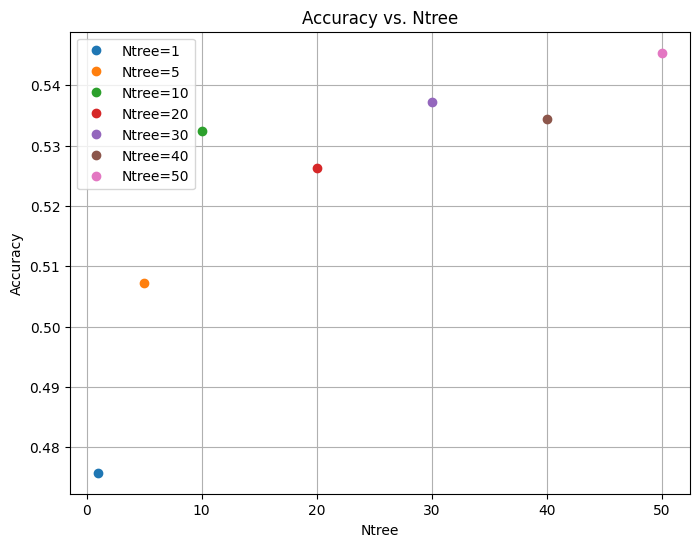

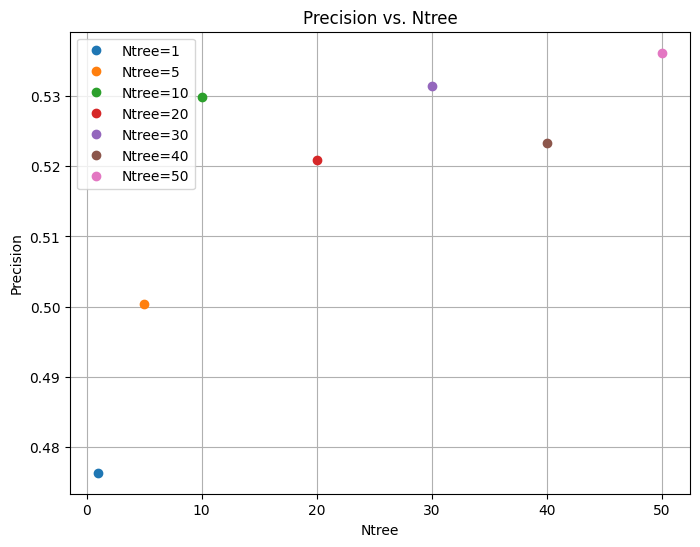

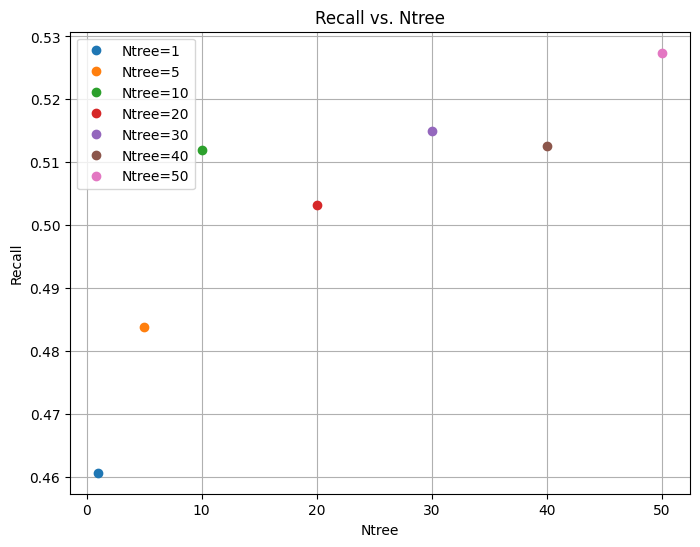

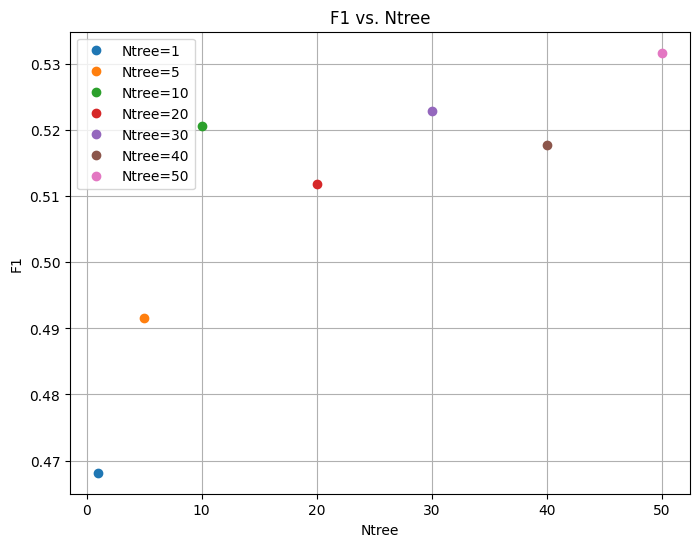

In [ ]:
k=5
max_depth=5
minimal_instances_for_split=3
run_random_forests(X, 'class',k,max_depth,minimal_instances_for_split)